What you need before “Run All”

- Diffusion model access: The notebook loads CompVis/stable-diffusion-v1-4. You must accept its license and be logged in with Hugging
Face (or switch the cell to sdxl‑turbo to avoid gating).
    - Login: huggingface-cli login (ensure your token has access), then rerun.
    - Or in the “pipeline” cell, comment the SD 1.4 line and uncomment the sdxl‑turbo lines.
- LLM backend:
    - If using Ollama (default in the demo cell): start a local server and pull a small model.
        - Start: `OLLAMA_HOME=/local/yada/ollama ollama serve` (in a separate shell)
        - Pull small model: ollama pull llama3.2:1b
        - In the LLM cell, either keep USE_OLLAMA=True and replace 'gemma3:27b' with 'llama3.2:1b', or pull a larger model if you have
the VRAM.
    - If using Google GenAI: set USE_OLLAMA=False and put your API key in GENAI_API_KEY.



USE `rattpo` environment created!

in a seprate shell, run:
```bash
# ollama pull gemma3:27b
OLLAMA_HOME=/local/yada/ollama OLLAMA_HOST=127.0.0.1:11434 ollama serve

```

# RATTPO Demo

- In this notebook, we showcase using RATTPO for prompt optimization with respect to Promptist Reward (Aesthetic + CLIP).
- VRAM Requirements: 8GB if used with external LLM API / 30GB if used with local LLM server (ollama).
- Runtime: depends on GPU, approximately 10 minutes for A6000.

In [12]:
## Imports and setups
import os
import sys
import json
import torch
import numpy as np
from pathlib import Path
from copy import deepcopy
from tqdm import tqdm
from utils import *
from typing import Dict, Union, List, Union
from functools import partial

## 1. Define Reward (Verifier)

In [13]:
import json
from typing import Dict, Union, List
from PIL import Image
import torch
from verifiers import SUPPORTED_VERIFIERS

class PromptistRewardVerifier():
    nickname = "promptist_reward"
    def __init__(self, base_score_path=None, device: str = None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.eval_target =  ["clipscore", "aesthetic"]
        self.verifiers = {k: SUPPORTED_VERIFIERS[k](device=device
            ) for k in self.eval_target}

        assert 'clipscore' in self.eval_target, "clipscore must be in eval_target"
        assert 'aesthetic' in self.eval_target, "aesthetic must be in eval_target"

        if base_score_path is not None:
            self.base_score_path = base_score_path
            with open(self.base_score_path, 'r') as f: # json file
                self.base_scores = json.load(f)

        
    def prepare_inputs(
        self,
        images: Union[list[Union[str, Image.Image]], Union[str, Image.Image]],
        prompts: Union[list[str], str],
        **kwargs,
    ):  
        return self.verifiers['clipscore'].prepare_inputs(images, prompts, **kwargs)

    def aggregate_to_one(self, results: List[Dict], method='mean') -> Dict:
        '''
        Aggregate given results to one dict.
        '''
        assert len(results) > 0, "results should not be empty"

        ret = {
                "reward": [],
                "verifier_scores": {
                        vname: []
                        for vname in self.verifiers.keys()
                    }
              }
        # append
        for single_result in results:
            ret['reward'].append(single_result['reward'])
            for vname in self.verifiers.keys():
                ret['verifier_scores'][vname].append(single_result['verifier_scores'][vname])
                    
        # mean
        assert method == 'mean', "only mean is supported for now"
        ret['reward'] = sum(ret['reward']) / len(ret['reward'])
        for vname in self.verifiers.keys():
            ret['verifier_scores'][vname] = sum(ret['verifier_scores'][vname]) / len(ret['verifier_scores'][vname])

        
        return ret

    def score(self, inputs: list[tuple[str, Union[str, Image.Image]]], ret_type='float', **kwargs):
        prompt_idx = getattr(kwargs, 'prompt_idx', 0) # should be in kwargs
        result = {}
        for vname, verifier in self.verifiers.items():
            result[vname] = verifier.score(inputs, ret_type=ret_type, **kwargs)

        prompt_adaptation_reward = []
        for i in range(len(inputs)):
            _clip = result["clipscore"][i]['reward']
            _aesthetic = result["aesthetic"][i]['reward']
            if hasattr(self, 'base_scores'):
                _base_aesthetic = self.base_scores["aesthetic"][str(prompt_idx)]
            else:
                _base_aesthetic = 0 # default base aesthetic score if not provided
            if isinstance(_base_aesthetic, list): # use mean as cache. seems okay if we don't know inference noise.
                _base_aesthetic = sum(_base_aesthetic) / len(_base_aesthetic) 
            f_rel = min(_clip / 100 * 20 - 5.6, 0) # clamped
            f_aes = _aesthetic - _base_aesthetic # delta aesthetic
            prompt_adaptation_reward.append(f_rel + f_aes)

        results = [
            {
                "reward": prompt_adaptation_reward[i],
                "verifier_scores": {
                    vname: result[verifier.nickname][i]['reward']
                    for vname, verifier in self.verifiers.items()
                }
            }
            for i in range(len(inputs))
        ]

        return results


In [14]:
verifier = PromptistRewardVerifier(device='cuda')

CLIP model loaded.


## 2. Choose Diffusion Backbone

In [15]:
num_images_per_prompt = 3
height, width = 512, 512

In [16]:
# default: sd1.4
pipe = AutoPipelineForText2Image.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None
pipe = pipe.to('cuda:0')
pipe.set_progress_bar_config(disable=True)

# make inference step and guidance scale configurable
pipe = partial(pipe, 
               height=height,
               width=width,
               negative_prompt=None,
               guidance_scale=7.5,
               num_inference_steps=20,
               num_images_per_prompt=num_images_per_prompt)  # access original pipe with pipe.func

# If you want to use sdxl-turbo: 
# Set the model name to "stabilityai/sdxl-turbo" and use one-step PNDMScheduler without guidance
# pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16)
# (...)

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


## 3. Setup RATTPO

In [17]:
# if you want to use local ollama server
USE_OLLAMA = True
# else if you want to use Google Generative AI API:
# get the key from https://aistudio.google.com/apikey and set it below.
GENAI_API_KEY = ""

In [18]:
from prompt_templates import get_prompt_template, get_hint_template
if USE_OLLAMA:
    import ollama

if not USE_OLLAMA:
    from google import genai
    from google.genai import types


class RATTPO():
    def __init__(self, config):
        self.search_rounds = config.search_rounds
        self.num_samples_per_round = config.num_samples_per_round
        # optimizer LLM configs
        self.template_version = config.template_version
        self.history_selection_strategy = config.history_selection_strategy
        self.history_num_selection = config.history_num_selection
        # hint generator LLM configs
        self.hint_history_selection_strategy = config.hint_history_selection_strategy
        self.hint_history_num_selection = config.hint_history_num_selection

        if not USE_OLLAMA:
            assert GENAI_API_KEY is not None, "GENAI_API_KEY must be set to use Google Generative AI API"
            self.genai_client = genai.Client(
                api_key=GENAI_API_KEY,
            )


    def propose(self, search_round: int, prompt: str):
        # Generate prompts to use
        if search_round == 1:
            # initialize
            self.hint = None
            self.history = []
            self.initial_prompt = prompt  # save the initial prompt
        prompts = self.query_optimizer_llm(search_round)

        return {"prompts": prompts}


    def update(self, search_round, datapoints):
        # save history
        for each in datapoints:
            one_inst = {
                'prompt': each['prompt'],
                'reward': each['reward'],
                'round': search_round,
            }
            self.history.append(one_inst)
        # sort the history based on the reward.
        self.history = sorted(self.history, key=lambda x: x['reward'], reverse=True)
        # update hint
        self.hint = self.query_hint_generator_llm()
        return None


    def _query_llm(self, _prompt):
        success = False
        num_tries = 0
        while not success:
            try:
                if USE_OLLAMA:
                    raw_response = ollama.chat(model='gemma3:27b', messages=[
                    {
                        'role': 'user',
                        'content': _prompt,
                    },])
                    ret = raw_response['message']['content']

                else:
                    contents = [
                        types.Content(
                            role="user",
                            parts=[types.Part.from_text(text=_prompt)],
                        ),
                    ]
                    raw_response = self.genai_client.models.generate_content(
                        model='gemma-3-27b-it',
                        contents=contents,
                    )
                    ret = raw_response.text
                success = True

            except Exception as e:
                num_tries += 1
                if num_tries > 3:
                    raise e
                print(f"Error in querying LLM: {e}")
                print(f"Retrying...")

        # clean up the response
        while ret.count('\n\n') > 1:
            ret = ret.replace('\n\n', '\n')
        ret = ret.strip()

        return ret

    def query_optimizer_llm(self, search_round: int) -> List[str]:
        _prompt = self._get_prompt(search_round)

        raw_response = self._query_llm(_prompt)  # query the LLM to get the initial prompt
        # parse the response
        parsed_response = raw_response[raw_response.find('1.'):].split('\n')
        ret = ['. '.join(each.split('. ')[1:]).strip() for each in parsed_response]  # remove the index
        # delete empty strings
        ret = [each for each in ret if each != '']

        return ret

    def query_hint_generator_llm(self) -> str:
        # setup metapromt for hint generator LLM.
        history = deepcopy(self.history)  # make a copy of the history
        # de-duplicate the history based on the prompt
        unique_history = {}
        for each in history:
            if each['prompt'] not in unique_history:
                unique_history[each['prompt']] = each
        history = list(unique_history.values())  # preserves the order of the dict since python 3.7

        num_context = min(self.hint_history_num_selection, len(history))  # prevent out of index error
        # first get the history based on selection strategy
        match self.hint_history_selection_strategy:
            case 'best':
                history = history[:num_context]  # select the best
            case 'all':
                history = history
            case 'random':  # randomly select
                history = np.random.choice(history, size=num_context, replace=False)
            case _:
                raise NotImplementedError(f"History selection strategy '{self.history_selection_strategy}' not implemented yet.")
        history_prompts = [each['prompt'] for each in history]
        history_scores = [each['reward'] for each in history]

        # now query LLM
        _prompt = get_hint_template(history_prompts=history_prompts,
                                    history_scores=history_scores,
                                    num_context=num_context,)                  
        return self._query_llm(_prompt)


    def _get_prompt(self, search_round: int) -> str:
        '''
        Generate prompt to query LLM.
        '''
        history = deepcopy(self.history)  # make a copy of the history
        unique_history = {}
        for each in history:
            if each['prompt'] not in unique_history:
                unique_history[each['prompt']] = each
        history = list(unique_history.values())

        num_context = min(self.history_num_selection, len(history))  # prevent out of index error
        history = history[:self.history_num_selection]  # select the best
        num_sample = self.num_samples_per_round

        # template
        history_prompts = [each['prompt'] for each in history]
        history_scores = [each['reward'] for each in history]

        num_context = min(self.history_num_selection, len(history_prompts))
        first_round_prompt, later_round_prompt = \
            get_prompt_template(version=self.template_version,
                                initial_prompt=self.initial_prompt,
                                num_sample=num_sample,
                                num_context=num_context,
                                history_prompts=history_prompts,
                                history_scores=history_scores,
                                hint=self.hint
                                )
        if search_round == 1 or self.history_selection_strategy == 'none':
            return first_round_prompt
        else:
            return later_round_prompt

In [19]:
from omegaconf import OmegaConf

# initialize config
rattpo_config = OmegaConf.create({
    "search_rounds": 20,
    "num_samples_per_round": 8,
    "template_version": "ours", 
    "history_num_selection": 8,
    "history_selection_strategy": "best",
    "hint_history_selection_strategy": "random",
    "hint_history_num_selection": 20
})

algo = RATTPO(rattpo_config)


## 4. Main Search Loop

Generated initial noise with shape torch.Size([3, 4, 64, 64]), seed 1234.


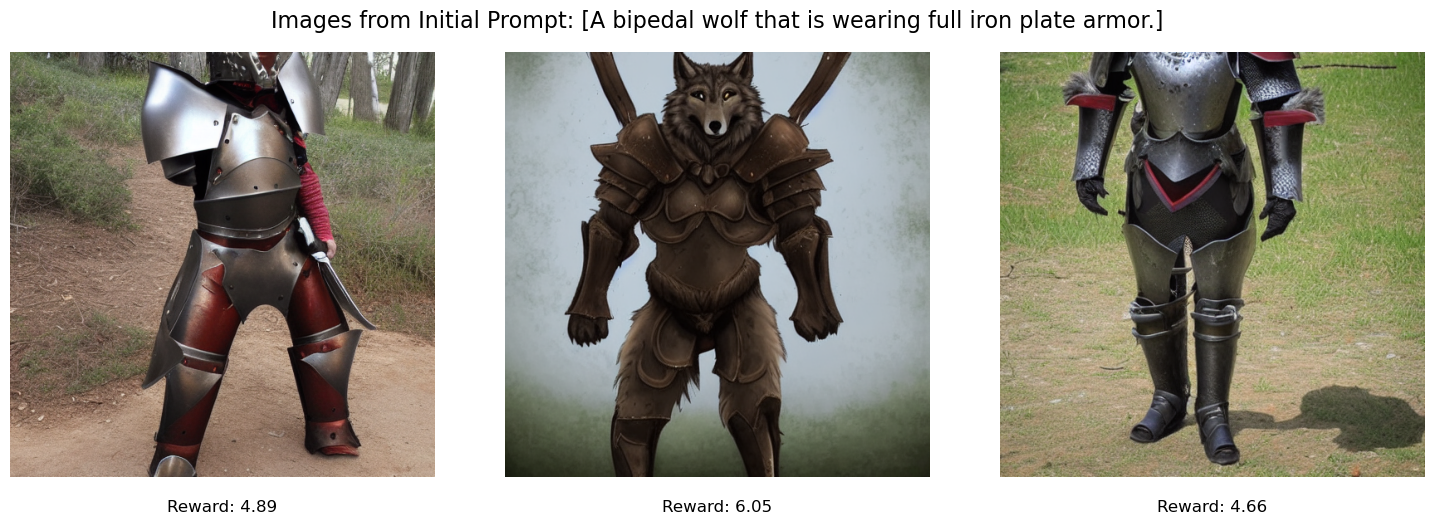

In [20]:
initial_prompt = "A bipedal wolf that is wearing full iron plate armor."

# first investigate initial prompt result
initial_noises = get_noises(
            noise_seed=1234,
            num_images_per_prompt=num_images_per_prompt,
            height=height,
            width=width,
            dtype=torch.float16,
        )
latents = initial_noises.clone()
initial_prompt_result = pipe(prompt=[initial_prompt], latents=latents)
# also scores
verifier_inputs = verifier.prepare_inputs(
    images=initial_prompt_result.images,
    prompts=[initial_prompt] * num_images_per_prompt
)
initial_scores = [each['reward'] for each in verifier.score(verifier_inputs)]

visualize_images(
    images=initial_prompt_result.images,
    scores=initial_scores,
    title=f"Images from Initial Prompt: [{initial_prompt}]"
)

In [ ]:
# Initialize
output_dir = f"demo_output/{initial_prompt.replace(' ', '_')}"
os.makedirs(output_dir, exist_ok=True)
batch_size_for_img_gen = 1

for search_round in tqdm(range(1, algo.search_rounds + 1), leave=False):
    round_output_dir = os.path.join(output_dir, f"round_{search_round}")
    os.makedirs(round_output_dir, exist_ok=True)

    ##########################################################
    #### 1. Get candidate prompts from the optimizer LLM #####
    ##########################################################
    proposal = algo.propose(search_round, initial_prompt)
    prompts = proposal["prompts"]


    ##########################################################
    #### 2. Generate images from the candidate prompts #######
    ##########################################################
    all_images = [] # order of all_images: (prompt0, noise0), (prompt0, noise1),  ..., (prompt1, noise0), ...
    # Generation in batch.
    for i in range(0, len(prompts), batch_size_for_img_gen):
        batched_prompts = prompts[i: i + batch_size_for_img_gen]
        repeat_shape = tuple([len(batched_prompts)] + [1] * (len(initial_noises.shape) - 1))
        latents = initial_noises.clone().repeat(repeat_shape)  # [num_images_per_prompt * batch_size, 4, 64, 64]
        batch_result = pipe(prompt=batched_prompts, latents=latents)
        batch_images = batch_result.images
        all_images.extend(batch_images)

    # save all generated images
    img_paths = []
    for i in range(len(all_images)):
        candidate_idx, noise_idx = divmod(i, num_images_per_prompt)
        img_paths.append(os.path.join(round_output_dir, 
                                      f"prompt_{candidate_idx}_{noise_idx}.png"))
                                    #   f"{prompts[candidate_idx].replace(' ', '_')}_{noise_idx}.png"))
    for _img, _path in zip(all_images, img_paths):
        _img.save(_path)


    ##########################################################
    #### 3. Evaluate the generated images with verifier ######
    ##########################################################
    # Prepare verifier inputs and perform inference.
    if getattr(verifier, 'nickname', None) == "vlmscore":
        # VLMVerifier requires image path and prompt as input
        verifier_inputs = verifier.prepare_inputs(images=img_paths, 
                                                  prompts=[initial_prompt] * len(img_paths))
    else:
        verifier_inputs = verifier.prepare_inputs(images=all_images,
                                                  prompts=[initial_prompt] * len(all_images))
    outputs = verifier.score(
        inputs=verifier_inputs,
        ret_type='float'
    )
    
    aggregated_outputs = [] # aggregate outputs from same prompt by averaging
    for i in range(len(prompts)):
        # slice all images generated from this prompt
        cur_outputs = outputs[i * num_images_per_prompt: (i + 1) * num_images_per_prompt]
        cur_img_paths = img_paths[i * num_images_per_prompt: (i + 1) * num_images_per_prompt]
        aggr = verifier.aggregate_to_one(cur_outputs, method='mean')
        aggr["initial_prompt"] = initial_prompt  # this is the original prompt
        aggr["prompt"] = prompts[i]  # later this is subject to change (prompt search)
        aggr["search_round"] = search_round
        aggr["img_path"] = cur_img_paths
        aggr["generation_idx"] = i
        aggregated_outputs.append(aggr)


    ##########################################################
    #### 4. Post-processing and logging the outputs ##########
    ##########################################################
    indices = list(range(len(aggregated_outputs))) # sort with score (higher better)
    order_pos = sorted(indices, key=lambda x: aggregated_outputs[x]['reward'], reverse=True)
    sorted_aggr_outputs = [aggregated_outputs[i] for i in order_pos]  # NOTE: not a deep copy
    # save
    result_json_filename = os.path.join(round_output_dir, f"result.json")
    with open(result_json_filename, "w") as f:
        json.dump(sorted_aggr_outputs, f, indent=4)
    # also save detailed outputs for each image
    for i in range(len(all_images)):
        candidate_idx, noise_idx = divmod(i, num_images_per_prompt)
        cur_prompt = prompts[candidate_idx]
        outputs[i]["prompt"] = cur_prompt  # later this is subject to change (prompt search)
        outputs[i]["search_round"] = search_round
        outputs[i]["img_path"] = img_paths[i]
        outputs[i]["generation_idx"] = candidate_idx
        outputs[i]["noise_idx"] = noise_idx
    indices = list(range(len(outputs)))
    order_pos = sorted(indices, key=lambda x: outputs[x]['reward'], reverse=True)
    result_json_filename = os.path.join(round_output_dir, f"detail.json")
    with open(result_json_filename, "w") as f:
        json.dump(outputs, f, indent=4)

    ##########################################################
    #### 5. update the internal state of search algorithm ####
    ##########################################################
    datapoints = sorted_aggr_outputs
    algo.update(search_round, datapoints)
    print(f"[Round {search_round}] Best Prompt: {algo.history[0]['prompt']}")
    print(f"Generated Hint: {algo.hint}")


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:17<05:34, 17.59s/it]

[Round 1] Best Prompt: A powerful bipedal wolf warrior, fully armored in intricately detailed iron plate, dynamic pose, cinematic lighting, fantasy illustration.
Generated Hint: Focus on detailed descriptions of materials, lighting, and artistic style, while emphasizing a dynamic pose and high resolution.


 10%|█         | 2/20 [00:29<04:20, 14.44s/it]

[Round 2] Best Prompt: A powerful bipedal wolf warrior, fully armored in intricately detailed iron plate, dynamic pose, cinematic lighting, fantasy illustration.
Generated Hint: Focus on detailed descriptions of armor, dynamic poses, lighting, and artistic style, while also specifying high resolution and realistic textures.


 15%|█▌        | 3/20 [00:43<03:59, 14.09s/it]

[Round 3] Best Prompt: A powerful bipedal wolf warrior, fully armored in intricately detailed iron plate, dynamic pose, cinematic lighting, fantasy illustration.
Generated Hint: Focus on combining strong descriptive adjectives (powerful, imposing, majestic), intricate details (engravings, weathering), and specific lighting/rendering terms (volumetric lighting, god rays, realistic textures) within a fantasy art context, consistently using "ultra high resolution" or "8k".


 20%|██        | 4/20 [00:56<03:39, 13.74s/it]

[Round 4] Best Prompt: Imposing bipedal wolf knight in full, intricately detailed iron plate armor, realistic fur textures, battle damage, dramatic god rays piercing through a misty forest, ultra high resolution, fantasy art.
Generated Hint: Focus on combining “realistic illustration/texture” with detailed descriptions of armor engravings, dynamic poses, and dramatic lighting effects like god rays, while consistently specifying high resolution (8k) and emphasizing the fantasy art style.


 25%|██▌       | 5/20 [01:10<03:28, 13.91s/it]

[Round 5] Best Prompt: Intricately detailed 8k illustration: a bipedal wolf warrior in full iron plate armor, dynamic pose, realistic fur, dramatic volumetric lighting, fantasy concept art.
Generated Hint: Focus on combining strong descriptive keywords (detailed, intricate, realistic, dramatic) with artistic styles (fantasy concept art, illustration) and technical details (8k, volumetric lighting, god rays) while emphasizing a dynamic pose and battle-worn textures.


KeyboardInterrupt: 

: 

## 5. Visualize Outputs

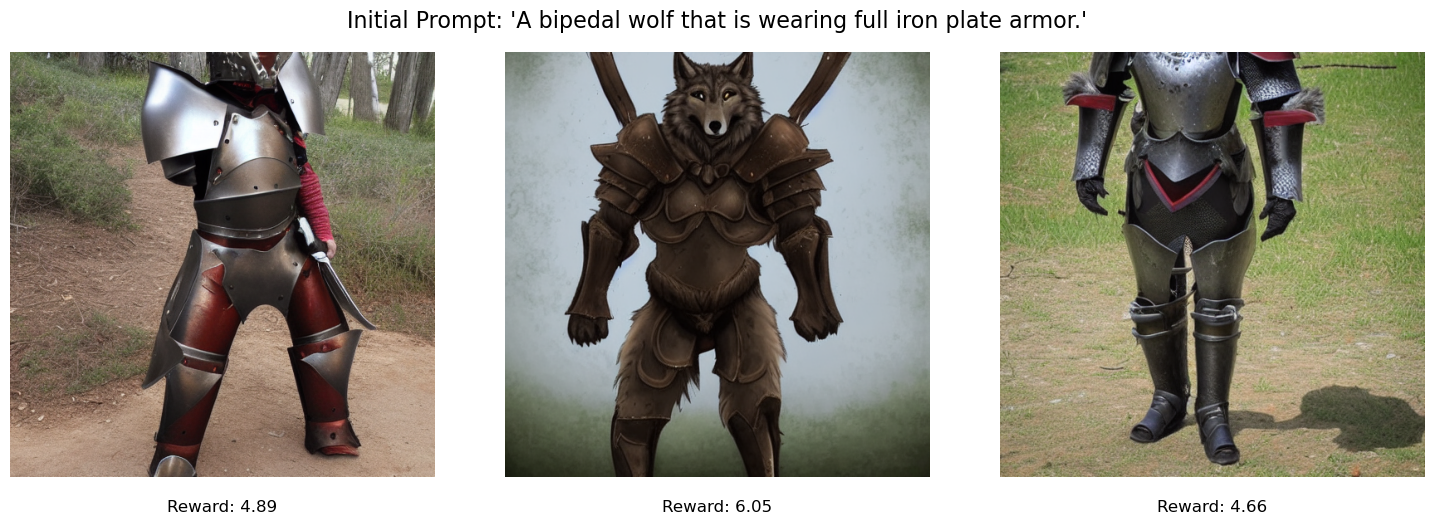

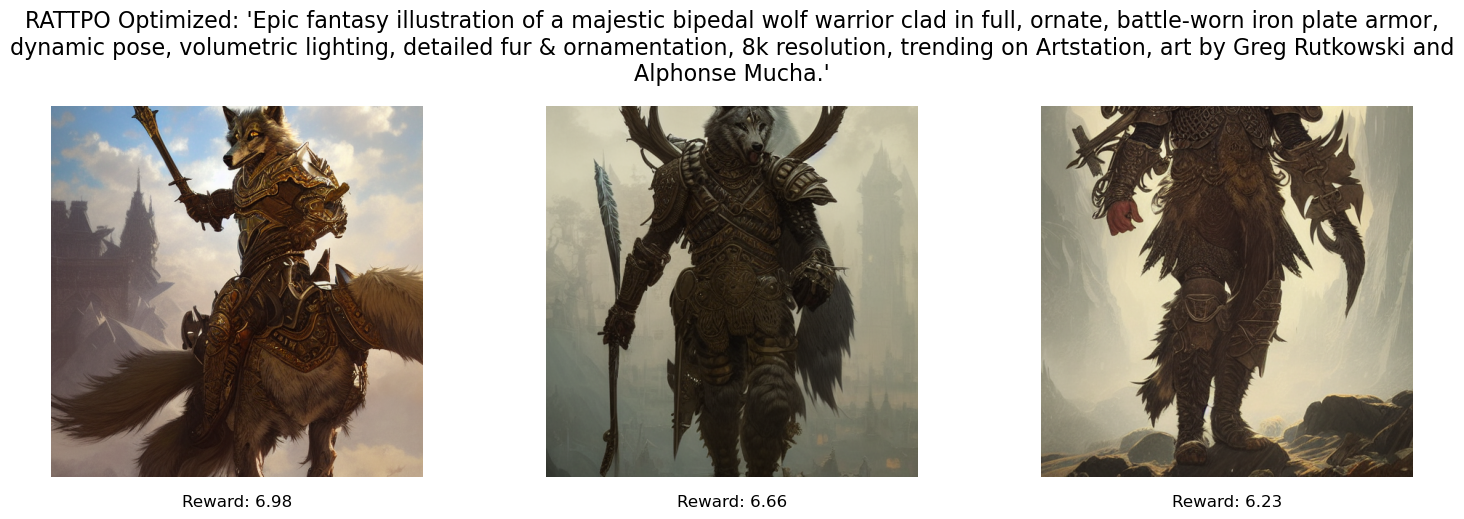

In [ ]:
best_prompt = algo.history[0]['prompt']
best_prompt_round = algo.history[0]['round']

with open(f"demo_output/{initial_prompt.replace(' ', '_')}/round_{best_prompt_round}/detail.json") as f:
    loaded_json = json.load(f)
    best_prompt_scores = []
    best_prompt_images = []
    for each in loaded_json:
        if each['prompt'] == best_prompt:
            best_prompt_scores.append(each['reward'])
            best_prompt_images.append(Image.open(each['img_path']))
    assert len(best_prompt_scores) == num_images_per_prompt, "Number of images does not match the number of scores."

# Initial
visualize_images(
    images=initial_prompt_result.images,
    scores=initial_scores,
    title=f"Initial Prompt: '{initial_prompt}'"
)
# RATTPO Best Prompt
visualize_images(
    images=best_prompt_images,
    scores=best_prompt_scores,
    title=f"RATTPO Optimized: '{best_prompt}'",
)